In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter

import os


In [2]:

# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()
#

'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

In [3]:
# ------ Hyperparameters ------ #
sampling_rate = 200 # in Hz

In [4]:
# load example data
exp_dict = {'LFP_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_LFP_signals_example/baseline1_OpenBCI-RAW-2025-01-05_17-16-53.txt'},
            'LFP_TTX':{'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_LFP_signals_example/ttx2_OpenBCI-RAW-2025-01-05_18-14-31.txt'} ,
            'O2_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_O2_signals_example/baseline1.txt'},
            'O2_TTX': {'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_O2_signals_example/ttx2.txt'}}

In [5]:

def create_lfp_df(file_name: str, sampling_rate: int, chan: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads a CSV file, keeps only 'time' and the specified 'chan' columns,
    and splits the result into 5-minute chunks based on the time column.

    :param file_name: Path to the CSV file.
    :param sampling_rate: Number of samples per second (used only to create the 'time' column
                          if the file does not already contain one).
    :param chan: The channel/column to keep in addition to 'time'.
    :return: A list of DataFrames, each corresponding to a 5-minute segment (300 seconds).
    """

    # Read the CSV file
    df = pd.read_csv(
        file_name,
        header=4,      # adjust if needed
        sep=', ',
        on_bad_lines='skip',
        engine='python'
    )

    # Create 'time' column using DataFrame index / sampling_rate (if needed)
    # If your CSV already has a 'time' column in seconds, you could skip this step
    row_indexes = np.array(df.index.tolist())
    df['time'] = row_indexes / sampling_rate

    # Keep only 'time' and the specified channel
    df = df[['time', chan]]

    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec
    df.rename(columns={chan: 'data'}, inplace=True)



   

    return df





def create_o2_df(file_path: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads an O2 data file and returns a DataFrame with 'time' and 'o2' columns.
    Skips the first 6 metadata lines.
    Assumes each subsequent line has two tab-separated columns: time_in_seconds and o2_value.
    """
    time_data = []
    o2_data = []

    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()

    # Skip metadata lines (the snippet shows ignoring the first 6 lines)
    for i in range(6, len(lines)):
        fields = lines[i].strip().split('\t')
        if len(fields) < 2:
            continue
        try:
            t = float(fields[0])
            o2_val = float(fields[1])
            time_data.append(t)
            o2_data.append(o2_val)
        except ValueError:
            continue

    df = pd.DataFrame({'time': time_data, 'data': o2_data})
    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec


    return df


In [6]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        file_path = params['file_path']
        lfp_df = create_lfp_df(file_path, sampling_rate, 'EXG Channel 0', params['start_sec'], params['stop_sec'])
        # add lfp_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = lfp_df
        
    elif 'O2' in exp_name:
        file_path = params['file_path']
        o2_df = create_o2_df(file_path, params['start_sec'], params['stop_sec'])
        # add o2_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = o2_df



In [39]:
def plot_lfp_fft(signal, time_array, freq_range, y_lim, tick_range, title, poly_order =10, line_width=2):
    """
    1) Compute FFT of the LFP 'signal' (numpy array).
    2) Limit freq range to [0, freq_high].
    3) Return a figure with a bar plot of the FFT amplitude.
    4) Y-limit is 0..y_lim.
    """
    # Compute sampling rate from time_array
    if len(time_array) < 2:
        # fallback
        sr = 1.0
    else:
        dt = np.mean(np.diff(time_array))
        if dt <= 0:
            sr = 1.0
        else:
            sr = 1.0 / dt
    print('SR: ', sr)
    # FFT
    fft_data = np.fft.rfft(signal)
    fft_freq = np.fft.rfftfreq(len(signal), d=1/sr)

    # Mask up to freq_high
    mask = (fft_freq >= freq_range[0]) & (fft_freq <= freq_range[1])
    freqs = fft_freq[mask]
    amps  = np.abs(fft_data[mask])

    # Build figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    ax.bar(freqs, amps, width=0.1, color='darkred')

    ax.set_xlabel("Frequency (Hz)", fontsize=26)
    ax.set_ylabel("Magnitude (µV)", fontsize=26)
    ax.set_xlim(0, 6)
    ax.set_ylim(y_lim[0], y_lim[1])
    plt.yticks(np.arange(0, y_lim[1] + 1, tick_range),fontsize=22 )
    plt.xticks(np.arange(0, 6 + 1, 1), fontsize=22)

    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    # ax.tick_params(labelsize=22)
    plt.title(title, fontsize=28)

    plt.show()

    return freqs, amps




In [40]:

def plot_o2_fft(signal, time_array, freq_range, y_lim, tick_range,title, poly_order=5, line_width=2):
    """
    Plot an FFT of a signal with a trend line.

    Args:
    signal (np.array): The signal data.
    time_array (np.array): Array of time points corresponding to the signal data.
    freq_range (tuple): The frequency range to plot (low, high).
    y_lim (int): The upper limit for the y-axis.
    tick_range (int): The spacing between ticks on the y-axis.
    yax (bool): If True, display the y-axis labels.
    poly_order (int): The order of the polynomial fit for the trend line.
    line_width (int): The width of the trend line.
    """

    sr = 1.0 / np.mean(np.diff(time_array))
    print('SR: ', sr)

    # FFT
    fft_data = np.fft.rfft(signal)
    fft_freq = np.fft.rfftfreq(len(signal), d=1/sr)

    # Mask up to freq_high
    mask = (fft_freq >= freq_range[0]) & (fft_freq <= freq_range[1])
    freqs = fft_freq[mask]
    amps  = np.abs(fft_data[mask])

    # Build figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    ax.bar(freqs, amps, width=0.1)

    ax.set_xlabel("Frequency (Hz)", fontsize=26)
    
    ax.set_ylabel("Amp (%Air)", fontsize=26)
    ax.set_xlim(0,6)
    # ax.set_ylim(y_lim[0], y_lim[1])
    plt.yticks(np.arange(y_lim[0], y_lim[1] + 1, tick_range), fontsize=22)
    plt.xticks(np.arange(0, freq_range[1] + 1, 1), fontsize=22)

    # Style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.title(title, fontsize=28)
   
    # plt.legend()
    plt.show()
    return freqs, amps


In [41]:


def plot_comb_fft_lfp(*args, labels, yax_range, o2_signal, title):
    """
    Plot multiple FFTs as smoothed lines on the same axes, highlighting differences, with filled areas under the curves.
    - `args`: Variable length argument list where each pair is (freqs, amps).
    - `labels`: List of labels for each FFT dataset.
    """
    # Setting up the plot
    # fig, ax = plt.subplots(figsize=(9, 6), dpi=600)  # Increase resolution to 600 DPI for high quality

    if not o2_signal:
        colors = ['gray', 'darkorange']
    else:
        colors = ['gray', 'darkgreen']
        colors = ['gray', 'darkorange']

    data = pd.DataFrame()
    for (freqs, amps), label in zip(args, labels):
        df_temp = pd.DataFrame({'Frequency': freqs, 'Magnitude': amps, 'Label': label})
        data = pd.concat([data, df_temp])

    if not o2_signal:
        bw_val = 0.01
    else:
        bw_val = 0.1

    # Density plot
    g = sns.displot(data, x="Frequency", hue="Label", weights="Magnitude", kind="kde", fill=True,
                    palette=colors, common_norm=True, height=4.2, aspect=1, bw_adjust=bw_val)
    # g.set_xlabels("Frequency (Hz)", fontsize=25)
    # if o2_signal:
        # g.set_ylabels("Magnitude Density (%Air)", fontsize=25)
    # else:
        # g.set_ylabels("Magnitude Density (µV)", fontsize=25)
    g.set_xticklabels(fontsize=26)
    g.set_yticklabels(fontsize=26)
    plt.title(title, fontsize=28)
    g.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    g.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # g.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xlim(0, 6)
    plt.xticks(np.arange(0, 6+1, 1),fontsize=26)
    if  o2_signal:
        plt.yticks(np.arange(yax_range[0], yax_range[1]+0.01, 0.05),fontsize=25 )

    plt.ylim(yax_range[0], yax_range[1])
    # no x and y labels
    plt.xlabel('')
    plt.ylabel('')

    plt.show()


SR:  200.0


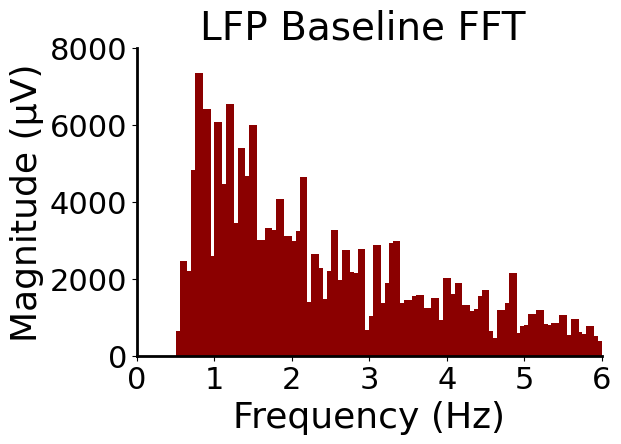

SR:  7.889447236180903


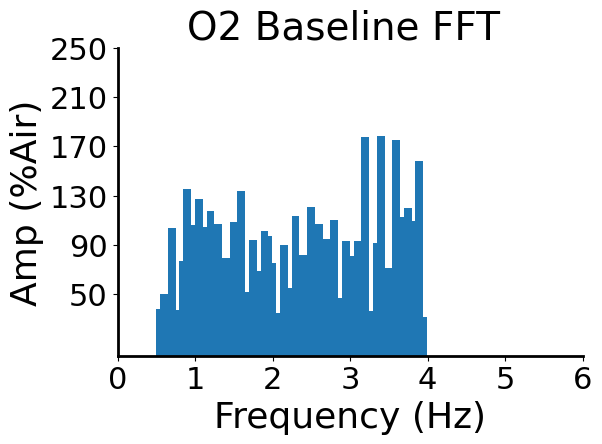

SR:  200.0


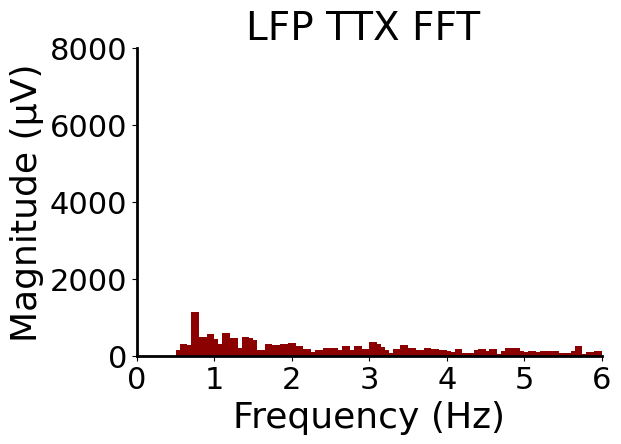

SR:  7.788944723618091


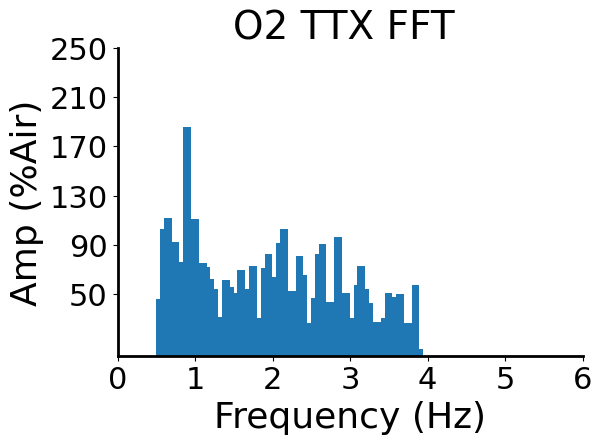

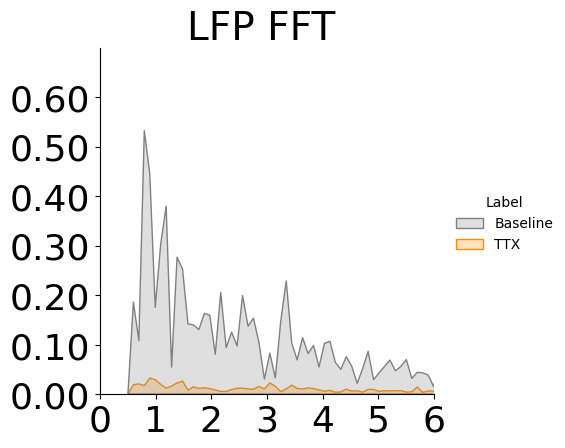

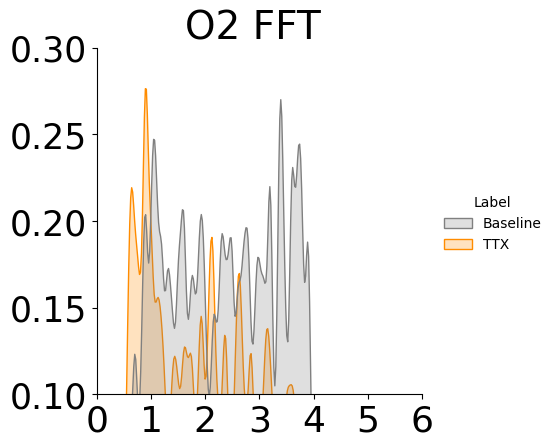

In [42]:


lfp_freqs_baseline, lfp_amps_baseline = plot_lfp_fft(signal = exp_dict['LFP_baseline']['data_df']['data'].values, time_array= exp_dict['LFP_baseline']['data_df']['time'].values, freq_range = (0.5, 20),y_lim = (0,8000),tick_range=  2000, title = 'LFP Baseline FFT ')
o2_freqs_baseline, o2_amps_baseline = plot_o2_fft(signal =exp_dict['O2_baseline']['data_df']['data'].values, time_array=exp_dict['O2_baseline']['data_df']['time'].values, freq_range =(0.5, 6),y_lim = (50,250),tick_range= 40, title = 'O2 Baseline FFT ')
lfp_freqs_ttx, lfp_amps_ttx = plot_lfp_fft(signal = exp_dict['LFP_TTX']['data_df']['data'].values, time_array= exp_dict['LFP_TTX']['data_df']['time'].values, freq_range = (0.5, 20),y_lim = (0,8000),tick_range=  2000, title = 'LFP TTX FFT ')
o2_freqs_ttx, o2_amps_ttx = plot_o2_fft(signal=exp_dict['O2_TTX']['data_df']['data'].values, time_array=exp_dict['O2_TTX']['data_df']['time'].values, freq_range =(0.5, 6),y_lim = (50,250),tick_range= 40, title = 'O2 TTX FFT ')
#
plot_comb_fft_lfp((lfp_freqs_baseline, lfp_amps_baseline),(lfp_freqs_ttx, lfp_amps_ttx),labels=['Baseline','TTX'],yax_range = (0,0.7), o2_signal= False, title = 'LFP FFT ')
plot_comb_fft_lfp((o2_freqs_baseline, o2_amps_baseline), (o2_freqs_ttx, o2_amps_ttx),labels=['Baseline','TTX'],yax_range = (0.1,0.3), o2_signal= True, title = 'O2 FFT ')
